### 1. Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import warnings 

warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (8, 8)

### 2. Загрузка данных

В папке с нашими данными присутствуют акции отдельных компаний, но нас интересует датасет со всеми компаниями, поэтому загрузим именно его

In [2]:
df = pd.read_csv(r"all_stocks_2006-01-01_to_2018-01-01.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM
1,2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM
2,2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM
3,2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM
4,2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM


### 3. Разведочный анализ данных (EDA)

Посмотрим по внимательней на наши данные
1. **Date** - дата продажи/покупки трейдинга
2. **Open** - цена на момент открытия акции
3. **High** - самая высокая цена акции
4. **Low** - самая низкая цена акции
5. **Close** - цена на момент закрытия
6. **Volume** - объём проданных акции
7. **Name** - название компании

In [3]:
df.tail()

,Date,Open,High,Low,Close,Volume,Name
93607,2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
93608,2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
93609,2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA
93610,2017-12-28,70.12,70.32,69.51,69.82,7556877,AABA
93611,2017-12-29,69.79,70.13,69.43,69.85,6613070,AABA


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93612 entries, 0 to 93611
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    93612 non-null  object 
 1   Open    93587 non-null  float64
 2   High    93602 non-null  float64
 3   Low     93592 non-null  float64
 4   Close   93612 non-null  float64
 5   Volume  93612 non-null  int64  
 6   Name    93612 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 5.0+ MB


Проверим данные на отсутствующие значения

In [5]:
df.isna().sum()

Date       0
Open      25
High      10
Low       20
Close      0
Volume     0
Name       0
dtype: int64

In [6]:
np.round(df.isna().sum() * 100 / len(df), 3)

Date      0.000
Open      0.027
High      0.011
Low       0.021
Close     0.000
Volume    0.000
Name      0.000
dtype: float64

В наших данных, как мы видим, наблюдаются некоторые отсутствующие значения. Так как данных много (93612) наблюдений, то тут можно пойти несколькими путями:
1. Отбросить строчки с пропущенными значениями
2. Заменить отсутствующие значения средними
3. Использовать интерполяцию в Pandas

В нашем случае воспользуемся **интерполяцией**:

In [7]:
df.interpolate(inplace = True)
np.round(df.isna().sum() * 100 / len(df), 3)

Date      0.0
Open      0.0
High      0.0
Low       0.0
Close     0.0
Volume    0.0
Name      0.0
dtype: float64

Теперь посмотрим более подробно на наши данные

In [8]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')

Для большего удобства приведём названия колонок к нижнему регистру

In [9]:
df.columns = [column.lower() for column in df.columns]
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'name'], dtype='object')

Посмотрим на общее количество данных для отдельно взятых индексов

In [10]:
df.name.value_counts()

JPM      3020
TRV      3020
NKE      3020
XOM      3020
BA       3020
KO       3020
MMM      3020
CAT      3020
MCD      3020
GS       3020
HD       3020
CVX      3020
AXP      3020
DIS      3020
VZ       3020
PG       3020
UTX      3020
UNH      3020
IBM      3020
GE       3020
JNJ      3020
WMT      3020
PFE      3020
MSFT     3019
AABA     3019
CSCO     3019
AMZN     3019
GOOGL    3019
INTC     3019
MRK      3019
AAPL     3019
Name: name, dtype: int64

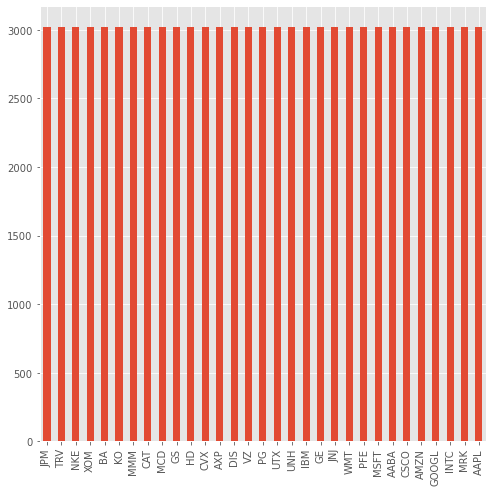

In [11]:
df.name.value_counts().plot(kind = 'bar');

Взглянем теперь на цены акций без учёта объёма продаж (Volume)

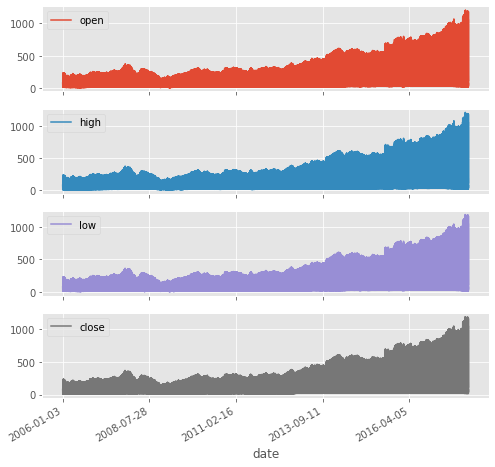

In [12]:
price_df = df[["date", "open", "high", "low", "close"]].copy()
price_df.set_index("date", inplace = True)
price_df.sort_index(inplace = True)
price_df.plot(subplots = True, kind = "line");

Взглянем на наши графики в более увеличенном масштабе с использованием среднего (MA), чтобы избавиться от сильной структуризации наших рядов. Также возьмём выборку за 2006 - 2008 года, чтобы не сильно нагружать систему и не ждать долго ответа от неё:

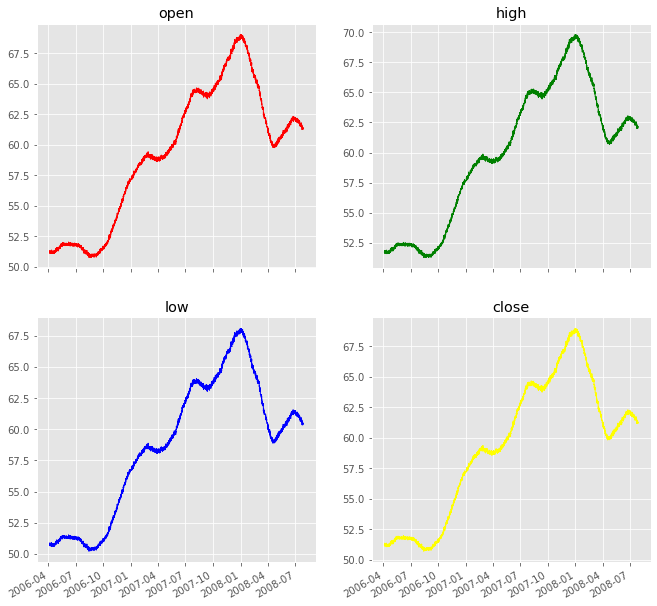

In [13]:
import matplotlib.dates as mdates
import datetime as dt

figure, axes = plt.subplots(2, 2, figsize = (11, 11))
k = 0
data = 20000
colors = ["red", "green", "blue", "yellow"]

price_df.index = pd.to_datetime(price_df.index) # Преобразуем
time_delta = dt.timedelta(days = 1) # Разница между днями
dates = mdates.drange(dt.datetime(2006, 1, 3), dt.datetime(2017, 12, 29), delta = time_delta) # Дата в формате matplotlib

for i in range(2):
    for j in range(2):
        figure.autofmt_xdate()  # Поворот даты и создание пространства между ними
        width = np.diff(dates).min() # Минимальная ширина между датами
        
        axes[i, j].plot(price_df.index[:data], price_df.iloc[:data, k].rolling(2000).mean(), color = colors[k],
                        label = price_df.columns[k], linewidth = width)
        axes[i, j].set_title(price_df.columns[k])
    
        k += 1

Как мы видими, графики для цен акций почти совпадают друг с другом. Проверим нулевую гипотезу о том, что средние 4 этих показателей равны, воспользовавшись ***однофакторным дисперсионным анализом (ANOVA)*** из пакета scipy.stats, но перед этим проверим наши данные на нормальность распределения и постоянство дисперсии. При несоблюдении хотя бы одного условия, придётся воспользоваться непараметрическим аналогом ANOVA

In [14]:
def plot_histogram_and_qq(data, column_name = "Гистограмма", distribution_type="norm", normal_tests = True):
    '''
    Рисует график распределения выборки, кривую нормального распределения для данных и график QQ-plot для оценки
    нормальности распределения. Дополнительно считает такие статистики, как:
        1. Минимальное и максимальное значение (Большинство наблюдений нормального распределения находятся в пределах трёх сигм от среднего)
        2. Среднее, моду, медиану (У нормально распределённых наблюдений эти три статистики будут примерно равны)
        3. Коэффициенты ассиметрии и эксцесса (У нормально распределённых данных эти две статистики примерно равны 0)
        
    Если параметру normal_tests передано значение True, то данные проверяются на нормальность распределения с помощью следующих
    статистических тестов:
        1. Тест Д'Агостино (Для выборок любой размерности)
        2. Тест Харка-Бера (Для выборок, размерность которых больше 2000)
        3. Тест Шапиро-Уилка (Для выборок, размерность которых не превышает 2000)
        
    
    Параметры
    ----------
    data: array_like
        Массив значений Numpy или Pandas
    
    column_name: str
        Название колонки с данными. По умолчанию имеет значение - Гистограмма
    
    distribution_type: str
        Предполагаемое распределение. По умолчанию имеет значение - norm
    
    normal_tests: bool
        Проверка на нормальность распределения с помощью статистических тестов (За доп. информацией - смотреть выше)
    
    '''
    
    mu = np.mean(data)
    sigma = np.std(data)
    
    # Plot histogram of the 1000 points
    plt.figure(figsize=(12,6))
    ax = plt.subplot(1,2,1)
    count, bins, ignored = plt.hist(data, 30, density=True)
    ax.set_title(column_name)
    ax.set_xlabel('Значения')
    ax.set_ylabel('Частота')

    # Overlay the bell curve (normal distribution) on the bins data
    bell_curve = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2))
    plt.plot(bins, bell_curve, linewidth=2, color='r')

    # Q-Q plot
    plt.subplot(1,2,2)
    res = stats.probplot(data, dist=distribution_type, plot=plt)
    # (osm, osr) = res[0]
    # (slope, intercept, r) = res[1]
    # For details see: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.probplot.html
    # print("slope, intercept, r:", slope, intercept, r)
    # print("r is the square root of the coefficient of determination")

    plt.show()
    
    print("-"*50)
    print("Мин/Макс значения: ", [np.min(data), np.max(data)])
    print("Правило трёх сигм: ", [mu - 3 * sigma, mu + 3 * sigma])
    print("Среднее/Мода/Медиана: ", [np.mean(data), stats.mode(data), np.median(data)])
    print("Ассиметрия/Эксцесс: ", [stats.skew(data), stats.kurtosis(data)])
    
    if normal_tests and distribution_type == "norm":
        print("-"*50)
        
        statistics, p = stats.normaltest(data)
        
        if p < 0.05:
            print("Д'Агостино тест: выборка взята не из нормального распределения! P-value: {}".format(p))
        else:
            print("Д'Агостино тест: выборка взята из нормального распределения. P-value: {}".format(p))
            
        if data.shape[0] > 2000:
            statistics, p = stats.jarque_bera(data)
            
            if p < 0.05:
                print("Харка-Бера тест: выборка взята не из нормального распределения! P-value: {}".format(p))
            else:
                print("Харка-Бера тест: выборка взята из нормального распределения. P-value: {}".format(p))
        else:
            statistics, p = stats.shapiro(data)
            
            if p < 0.05:
                 print("Шапиро тест: выборка взята не из нормального распределения! P-value: {}".format(p))
            else:
                print("Шапиро тест: выборка взята из нормального распределения. P-value: {}".format(p))

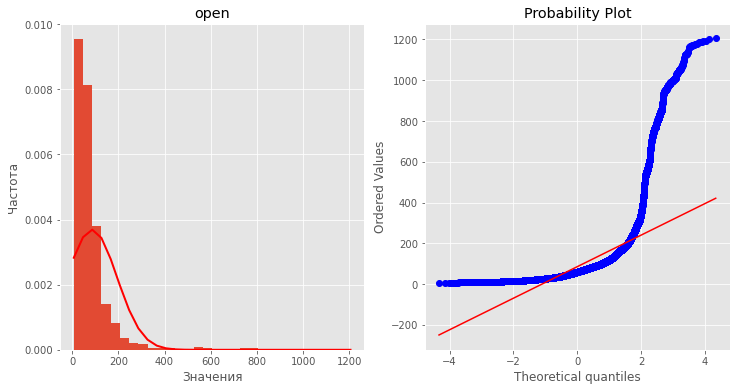

--------------------------------------------------
Мин/Макс значения:  [6.75, 1204.88]
Правило трёх сигм:  [-238.79487833861907, 410.05488805959504]
Среднее/Мода/Медиана:  [85.63000486048797, ModeResult(mode=array([34.]), count=array([38])), 60.04]
Ассиметрия/Эксцесс:  [5.078976972554121, 32.7470329370476]
--------------------------------------------------
Д'Агостино тест: выборка взята не из нормального распределения! P-value: 0.0
Харка-Бера тест: выборка взята не из нормального распределения! P-value: 0.0


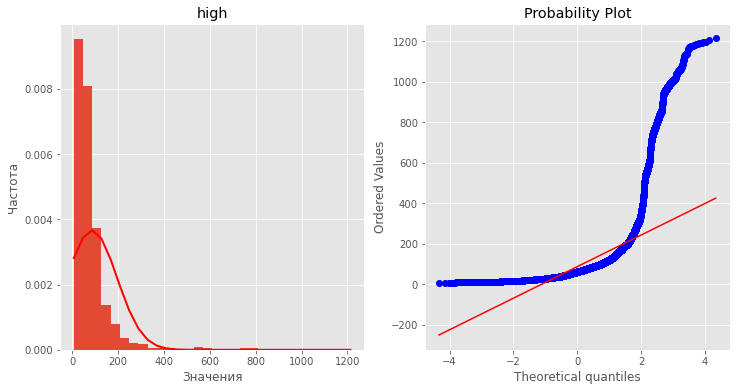

--------------------------------------------------
Мин/Макс значения:  [7.17, 1213.41]
Правило трёх сигм:  [-240.46752131168844, 413.2468279176894]
Среднее/Мода/Медиана:  [86.38965330300047, ModeResult(mode=array([50.]), count=array([44])), 60.63]
Ассиметрия/Эксцесс:  [5.07064714803763, 32.63148683480338]
--------------------------------------------------
Д'Агостино тест: выборка взята не из нормального распределения! P-value: 0.0
Харка-Бера тест: выборка взята не из нормального распределения! P-value: 0.0


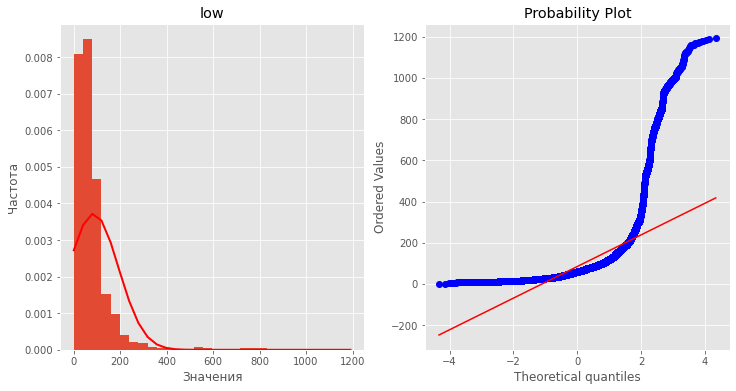

--------------------------------------------------
Мин/Макс значения:  [0.0, 1191.15]
Правило трёх сигм:  [-236.8101690615, 406.4966778424165]
Среднее/Мода/Медиана:  [84.84325439045824, ModeResult(mode=array([27.]), count=array([48])), 59.5]
Ассиметрия/Эксцесс:  [5.084301287863232, 32.83587906065665]
--------------------------------------------------
Д'Агостино тест: выборка взята не из нормального распределения! P-value: 0.0
Харка-Бера тест: выборка взята не из нормального распределения! P-value: 0.0


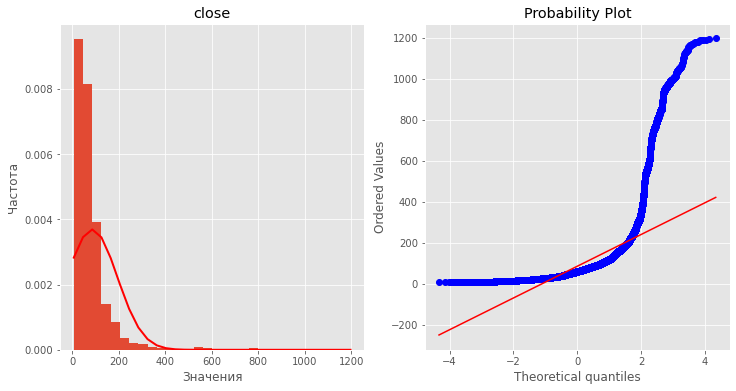

--------------------------------------------------
Мин/Макс значения:  [6.66, 1195.83]
Правило трёх сигм:  [-238.71983364082934, 410.0033393879558]
Среднее/Мода/Медиана:  [85.64175287356323, ModeResult(mode=array([27.04]), count=array([28])), 60.05]
Ассиметрия/Эксцесс:  [5.0780995065745405, 32.74195662446125]
--------------------------------------------------
Д'Агостино тест: выборка взята не из нормального распределения! P-value: 0.0
Харка-Бера тест: выборка взята не из нормального распределения! P-value: 0.0


In [15]:
for column in price_df.columns:
    plot_histogram_and_qq(price_df[column], column_name = column, normal_tests = True, distribution_type = "norm")

Как мы видим, все 4 показателя не имеют нормального распределения. Воспользуемся в таком случае для проверки нулевой гипотезы о равенстве средних непараметрическим аналогом ANOVA - **критерием Краскелла-Уоллиса**

In [16]:
_, p_value = stats.kruskal(price_df["open"], price_df["high"], price_df["low"], price_df["close"])

if p_value < 0.05:
    print("Средние не равны! P-value: {}".format(p_value))
else:
    print("Средние примерно равны. P-value: {}".format(p_value))

Средние не равны! P-value: 9.123342584413958e-07


Посмотрим на корреляционную зависимость между нашими показателями (также проверим её на значимость), воспользовавшись коэффициентом корреляции Пирсона:

In [17]:
price_df.corr()

,open,high,low,close
open,1.000000,0.999944,0.999922,0.999884
high,0.999944,1.000000,0.999908,0.999943
low,0.999922,0.999908,1.000000,0.999946
close,0.999884,0.999943,0.999946,1.000000


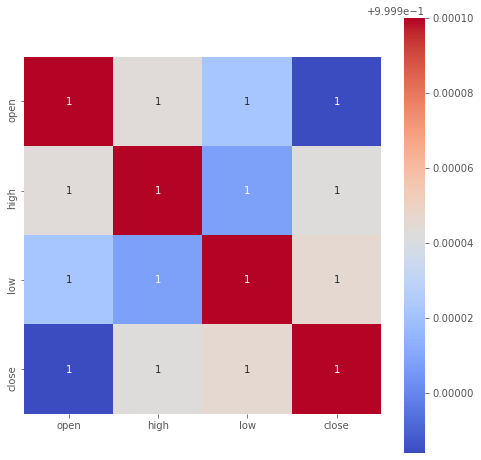

In [18]:
sns.heatmap(price_df.corr(), cmap = "coolwarm", annot = True, fmt = ".3g", square = True);

In [19]:
def correlation_pearson(data):
        for i in range(data.shape[1]):
            for j in range(i, data.shape[1]):
                statistics, p_value = stats.pearsonr(data[:, i], data[:, j])
                
                if p_value < 0.05:
                    print((statistics, p_value), "- cтатистически значим")
                else:
                    print((statistics, p_value), "- cтатистически не значим")

In [20]:
correlation_pearson(price_df.values)

(1.0, 0.0) - cтатистически значим
(0.9999436832589493, 0.0) - cтатистически значим
(0.9999218549777091, 0.0) - cтатистически значим
(0.9998839123602561, 0.0) - cтатистически значим
(0.9999999999999998, 0.0) - cтатистически значим
(0.9999078909695238, 0.0) - cтатистически значим
(0.999942857760939, 0.0) - cтатистически значим
(0.9999999999999997, 0.0) - cтатистически значим
(0.9999459164424302, 0.0) - cтатистически значим
(0.9999999999999994, 0.0) - cтатистически значим


Как можем наблюдать, есть очень сильная статистическая взаимосвязь между нашими переменными. Приступим к моделированию одного нашего показателя. Пускай это будет максимальная стоимость акции **(High)**.

In [21]:
print(df["name"].unique(), len(df["name"].unique()))

['MMM' 'AXP' 'AAPL' 'BA' 'CAT' 'CVX' 'CSCO' 'KO' 'DIS' 'XOM' 'GE' 'GS'
 'HD' 'IBM' 'INTC' 'JNJ' 'JPM' 'MCD' 'MRK' 'MSFT' 'NKE' 'PFE' 'PG' 'TRV'
 'UTX' 'UNH' 'VZ' 'WMT' 'GOOGL' 'AMZN' 'AABA'] 31


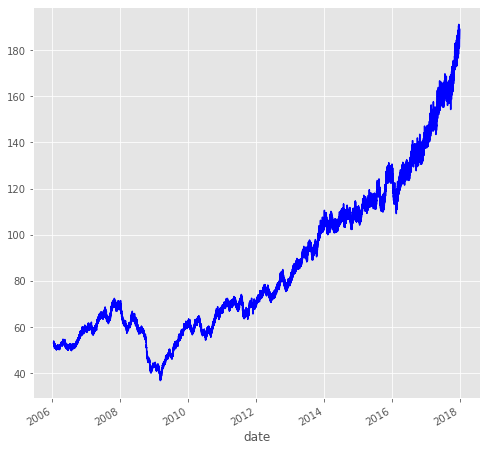

In [22]:
price_df["high"].rolling(300).mean().plot(color = "blue");

Проверим с помощью теста **Дикки-Фуллера** и **KPSS** на наличие нестационарности нашего ряда. Важно помнить, что в KPSS тесте проверяется нулевая гипотеза о том, что ряд является ***стационарным***. В то время как в тесте Дикки-Фуллера проверяется нулевая гипотеза о том, что ряд имеет единичный корень, то есть ряд ***нестационарный***

In [65]:
import statsmodels.tsa as ts


def KPSS_adfuller(series):
    values = ts.stattools.kpss(price_df["high"])
    p_value = values[1]

    if p_value < 0.05:
        print("KPSS: Ряд не является стационарным. P-value: {}".format(p_value))
    else:
        print("KPSS: Ряд является стационарным. P-value: {}".format(p_value))

    values = ts.stattools.adfuller(price_df["high"])
    p_value = values[1]

    if p_value < 0.05:
        print("Дикки-Фуллера: Ряд является стационарным. P-value: {}".format(p_value))
    else:
        print("Дикки-Фуллера: Ряд не является стационарным. P-value: {}".format(p_value))

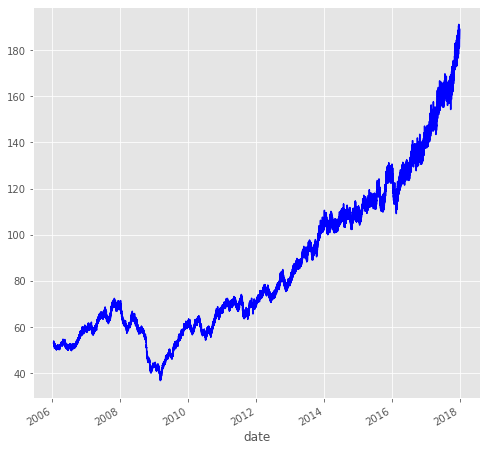

In [24]:
price_df["high"].rolling(300).mean().plot(color = "blue");

Как мы видим, показания тестов значительно отличаются друг от друга. Посмотрим на график ещё раз, явно виден восходящий тренд, что говорит нам о том, что ряд является нестационарным. Также можно заметить ещё и то, что ряд является гетероскедастичным (дисперсия в разные моменты времени разная), что также говорит в пользу нестационарности.

### 4. Тренировка моделей 

Раз уж мы наблюдаем немонотонность дисперсии нашего ряда, то нам придётся её стабилизоровать. Это делается с помощью **семейства преобразований Бокса-Кокса**, но так как это преобразование степенное, то необходимо проверить наш ряд на наличие отрицательных значений

In [25]:
price_df["high"].describe()

count    93612.000000
mean        86.389653
std        108.952973
min          7.170000
25%         34.290000
50%         60.630000
75%         94.740000
max       1213.410000
Name: high, dtype: float64

Как мы видим, нам не придётся сдвигать на константу наши данные, так как отрицательные значения не наблюдаются. Можно сделать преобразование, главное - не забыть сделать обратное преобразование при прогнозировании нашего ряда

In [26]:
# Преобразование Бокса-Кокса
transformed_high, lambda_const = stats.boxcox(price_df["high"])
transformed_high = pd.DataFrame(transformed_high, index = df["date"], columns = ["high"])

-0.19816854982600016

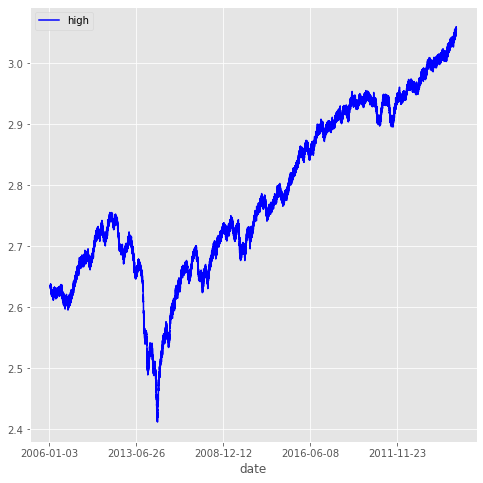

In [27]:
transformed_high.rolling(300).mean().plot(color = "blue")
lambda_const

Как видим, дисперсия более менее стабилизировалась, но ряд всё также нестационарен .Попробуем избавиться от нестационарности, путём дифференцирования ряда:

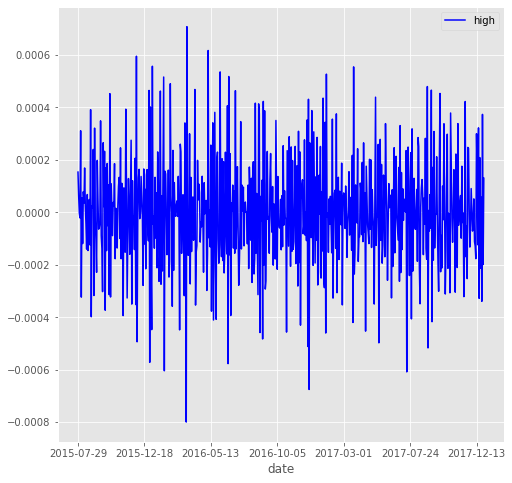

In [81]:
transformed_high[90000:].diff(1).rolling(3000).mean().plot(color = "blue");

In [82]:
KPSS_adfuller(transformed_high.diff(1))

KPSS: Ряд не является стационарным. P-value: 0.01
Дикки-Фуллера: Ряд является стационарным. P-value: 2.3227531614207683e-10


Проверим дифференцированный ряд на стационарность (У стационарного ряда постоянные мат. ожидание, дисперсия и ковариация)

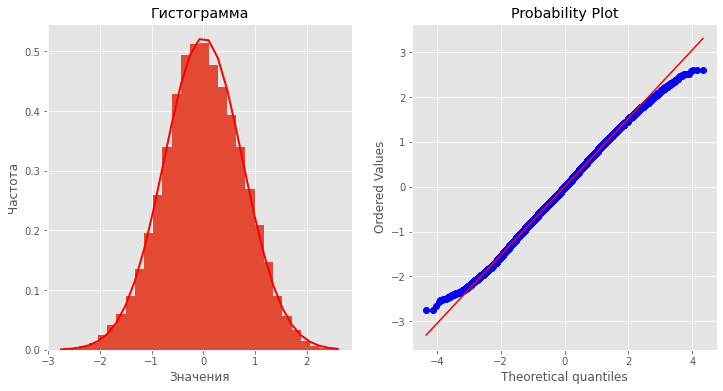

--------------------------------------------------
Мин/Макс значения:  [-2.7570884954055526, 2.602721927428689]
Правило трёх сигм:  [-2.2881072571767445, 2.288117761869422]
Среднее/Мода/Медиана:  [5.25234633891796e-06, ModeResult(mode=array([-2.7570885]), count=array([1])), -0.008516363748811484]
Ассиметрия/Эксцесс:  [-0.03589485102201712, -0.15674785791943968]
--------------------------------------------------
Д'Агостино тест: выборка взята не из нормального распределения! P-value: 1.3506123124768868e-29
Харка-Бера тест: выборка взята не из нормального распределения! P-value: 0.0


In [103]:
# Избавляемся от nan значений
histogram_data = transformed_high.diff(1).values.reshape(-1)
histogram_data = histogram_data[~np.isnan(histogram_data)] 
# Проверка на нормальность распределения
plot_histogram_and_qq(histogram_data,  normal_tests = True, distribution_type = "norm")

Как мы видим, для нашего ряда оптимальным порядком дифференцирования является d = 1, что хорошо видно по графику. Посмотрим на автокорреляционную функцию нашего ряда (**ACF**) и частичную автокорреляционную функцию (**PFC**)

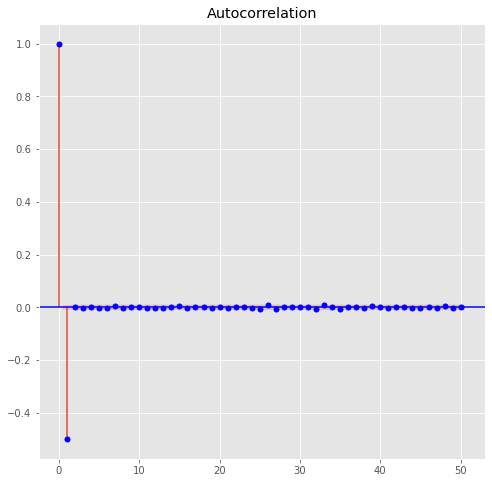

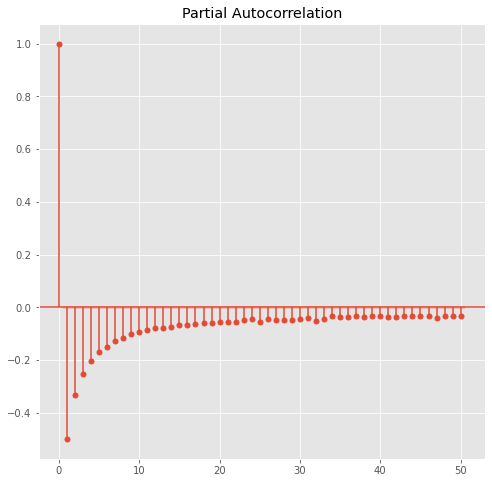

In [69]:
acf = sm.graphics.tsa.plot_acf(transformed_high[1:].values.squeeze(), color = 'blue', lags=50, alpha = 0.01)
pacf = sm.graphics.tsa.plot_pacf(transformed_high[1:].values.squeeze())

acf.show()
pacf.show()

Судя по коррелограмме, на большинстве лагах мы можем отвергнуть нулевую гипотезу об отсутствии автокорреляции. Попробуем натренировать нашу ARIMA c использованием кросс-валидации

In [93]:
from sklearn.metrics import mean_absolute_error

In [131]:
def evaluate_arima_model(X, arima_order, return_model = False, print_info = False):
    # Подготовим данные для кросс-валидации. Разделим выборку на тренировочный набор данных и тестовый
    size = int(len(X) * 0.66) # 66% наблюдений будет в тренировочном наборе, 34% в тестовом
    
    train, test = X[0:size], X[size:] # Тренировочный и тестовый наборы данных
    history = [x for x in train]
    # predictions = np.array()
    predictions = list()
    
    # print("Тестовая выборка: ", len(test))
    
    
    for t in range(len(test)):
        model = ts.arima.model.ARIMA(history, order = arima_order)
        model_fit = model.fit()
    
        output = model_fit.forecast()
        yhat = output[0] # метод forecast возвращает вектор, состоящий из одного значения, поэтому [0]
        
        # predictions = predictions.append(yhat) # Предсказания модели
        predictions.append(yhat)
        obs = test[t]  # Наблюдаемые значения
        history.append(obs)
        
        if print_info:
            print(t, 'predicted=%f, expected=%f' % (yhat, obs))
    
    mae = mean_absolute_error(test, predictions)
    
    if print_info:
        print("MAE=%.3f" % (mae))
    
    if return_model:
        return model_fit
        print("MAE=%.3f" % (mae))
    else:
        return mae

In [132]:
def evaluate_models(dataset, p_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for q in q_values:
            order = (p,1,q)
            try:
                mae = evaluate_arima_model(dataset, order)
                if mae < best_score:
                    best_score, best_cfg = mae, order
                print('ARIMA%s MAE=%.3f' % (order, mae))
            except:
                continue
    print('Best ARIMA%s MSA=%.3f' % (best_cfg, best_score))

In [126]:
size = 1000
data = transformed_high.shape[0] - size

In [133]:
p_values = range(0, 4)
q_values = range(0, 4)
evaluate_models(transformed_high.values[data:], p_values, q_values)

ARIMA(0, 1, 0) MAE=0.653
ARIMA(0, 1, 1) MAE=0.372
ARIMA(0, 1, 2) MAE=0.249
ARIMA(0, 1, 3) MAE=0.248
ARIMA(1, 1, 0) MAE=0.463
ARIMA(1, 1, 1) MAE=0.304
ARIMA(1, 1, 2) MAE=0.248
ARIMA(1, 1, 3) MAE=0.248
ARIMA(2, 1, 0) MAE=0.394
ARIMA(2, 1, 1) MAE=0.297
ARIMA(2, 1, 3) MAE=0.248
ARIMA(3, 1, 0) MAE=0.381
ARIMA(3, 1, 1) MAE=0.297
ARIMA(3, 1, 2) MAE=0.253
ARIMA(3, 1, 3) MAE=0.249
Best ARIMA(2, 1, 3) MSA=0.248


Как мы видим, наилучшим вариантом для нас будет ARIMA с параметрами:
1. p = 0
2. d = 1
3. q = 3
<br>
Подходят и конфигурации (1, 1, 2), (1, 1, 3) и т.д., но особого прироста в точности у них нет, не считая вычислительных затрат

In [134]:
transformed_sample = transformed_high[data:]

In [137]:
%%time
arima_model = evaluate_arima_model(transformed_sample.values, (0, 1, 3), return_model = True, 
                                   print_info = False)
arima_model.summary()

Wall time: 6min 53s


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  999
Model:                 ARIMA(0, 1, 3)   Log Likelihood                -317.128
Date:                Sun, 07 Feb 2021   AIC                            642.257
Time:                        14:46:39   BIC                            661.880
Sample:                             0   HQIC                           649.715
                                - 999                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.0636      0.054    -38.143      0.000      -2.170      -1.958
ma.L2          1.1283      0.078     14.453      0.000       0.975       1.281
ma.L3         -0.0645      0.034     -1.910      0.056      -0.131       0.002
sigma2         0.1083      0.006     16.671      0.000       0.096       0.121
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                16.72
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.00
Prob(H) (two-sided):                  0.98   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [144]:
predicted_arima = arima_model.predict(start = 0, end = len(transformed_sample) - 1)

In [145]:
predicted_arima.shape

(1000,)

In [147]:
def invboxcox(data, lambda_const):
    if lambda_const == 0:
        return (np.exp(data))
    else:
        return (np.exp(np.log(lambda_const * data + 1) / lambda_const))

reverse_data = pd.DataFrame(invboxcox(predicted_arima, lambda_const), columns = ["high"])

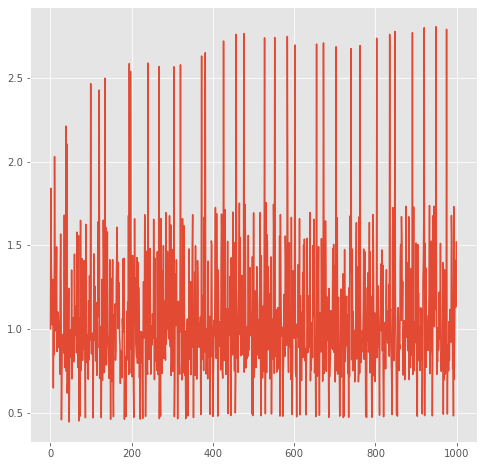

In [150]:
plt.plot(reverse_data)

Что ж, как мы видим, ARIMA не очень справилась с поставленной задачей, скорее всего это связано с неэффективным подбором гиперпараметров или наличием сезонности, которую мне не удалось обнаружить в данных.